#### Things to add on:
* graphs to illustrate the differences in the sampling methods

# Using Logistic Regression with Oversampling

In this notebook, I'll be analyzing this dataset with the Logistic Regression model. Due to the imbalance of the dataset, I'll be using and comparing a few oversampling methods to deal with this imbalance issue.

In [1]:
import pandas as pd
df = pd.read_csv('data/res_anon_working.csv')

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
                             precision_recall_fscore_support, 
                             average_precision_score, 
                             roc_auc_score, 
                             confusion_matrix,
                             precision_recall_curve)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,Class
0,4,0.0,1.0,48.0,3,0,0,1,0,0,0,0,1,0,1,0,0,0.0,7.138867,0.0
1,7,0.0,1.0,125.0,3,0,1,1,0,0,0,0,0,0,0,0,0,0.0,7.138867,0.0
2,2,0.0,1.0,14.0,3,0,0,1,0,0,0,0,1,0,1,0,0,0.0,7.727535,0.0
3,3,0.0,1.0,67.0,2,0,1,1,0,1,0,0,0,0,0,1,0,0.0,7.727535,0.0
4,5,0.0,1.0,117.0,2,0,0,1,0,0,0,1,0,0,0,0,0,0.0,7.727535,0.0


#### Understanding the dataset

As you can see from above, the rows represent the observations (i.e. 1 row is 1 reservation) and the columns 'F1' to 'F19' represent the features/characteristics of each observation. The last column 'Class' states whether a particular reservation has a voucher purchase or not, with '0' representing no vouchers bought and '1' representing 1 or more vouchers bought. 

#### Defining X and y

In [4]:
feat_lst = list(df)
feat_lst.pop(-1)
feat_lst

['F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'F10',
 'F11',
 'F12',
 'F13',
 'F14',
 'F15',
 'F16',
 'F17',
 'F18',
 'F19']

In [5]:
X = df[feat_lst]
y = df['Class']

#### Looking at the data imbalance

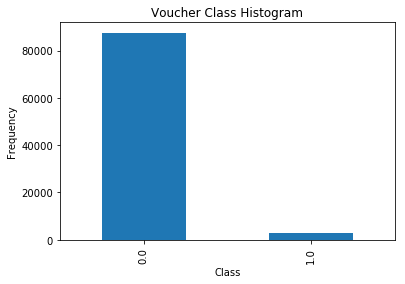

In [6]:
count_classes = pd.value_counts(df['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Voucher Class Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

As you can see, the data is hugely imbalanced. This is mainly because this voucher product is only recenty released by the company, and the data that we received includes data from the period when this product was not released yet. This class imbalance will affect our model accuracy greatly, so resampling of the data is needed in order to train the model properly. But let's proceed without any resampling of data to see where this goes.

#### Defining model evaluation functions

In [7]:
def model_eval(X, y, model):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(confusion_matrix(y, y_pred))
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print('Precision: %f' % (float(tp)/(tp + fp)))
    print('Recall: %f' % (float(tp)/(tp + fn)))
    y_proba = model.predict_proba(X)[:,1]
    print('AUC: %f' % roc_auc_score(y, y_proba))

# AUC under ROC curve should be using the probabilities of each sample instead of the actual label for each sample
# Hence, it must be using predict_proba and not predict

In [8]:
def graph_eval(X, y, model):
    p_range = np.arange(0.1, 1, 0.1) 
    p_range
    precisions = []
    recalls = []
    f1s = []
    prob_range = []

    pred = model.predict_proba(X)
    for p in p_range:

        pred_tmp = pred[:, 1].copy()
        pred_tmp[pred_tmp > p] = 1
        pred_tmp[pred_tmp <= p] = 0
        tn, fp, fn, tp = confusion_matrix(y, pred_tmp).ravel()
        if tp == 0: 
            continue
        prec = (float(tp)/(tp + fp))
        rec = (float(tp)/(tp + fn))
        f1 = 2 * prec * rec / (prec + rec)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
        prob_range.append(p)

    # plot the results
    plt.plot(prob_range, precisions, 'k', label='Precision')
    plt.plot(prob_range, recalls, 'g', label='Recall')
    plt.plot(prob_range, f1s, 'b', label='F1')
    plt.xlabel('Prob Range')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1))

In [9]:
def pr_eval(X, y, model):
    y_proba = model.predict_proba(X)[:,1]
    average_precision = average_precision_score(y, y_proba)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    
    precision, recall, _ = precision_recall_curve(y, y_proba)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))


#### Fitting and testing out the model without any resampling of data

In [10]:
logreg = LogisticRegression(C=1e9) 
logreg.fit(X, y)
y_proba = logreg.predict_proba(X)[:,1]
# model.predict returns an array of predicted labels of each sample, so it shows either 0 or 1 for each sample
# model.predict_proba returns an array of the probabilities that each sample is a 0 or 1
# [:,1] means only display the probability that the sample is a 1
y_proba

array([ 0.07377792,  0.04539307,  0.06864738, ...,  0.00696756,
        0.00634766,  0.00636809])

In [11]:
model_eval(X, y, logreg)

[[87558     0]
 [ 2873     1]]
Accuracy: 96.82%
Precision: 1.000000
Recall: 0.000348
AUC: 0.640621


As you can see, I have received an accuracy of 96.82%, which is supposed to be amazing, but when you look at the other evaluating metrics, the results shows otherwise. Because of how poorly imbalanced this dataset is, the model classifies all instances except for 1 under the negative class. As a result, it wrongly classifies ALL the other 2873 postive classes, hence giving the horrific recall rate of 0.000348. The precision is 1 because the model manages to correctly classify one instance as a positive class, which does not mean much.

This is not what we want. We want our model to accurately pick out the positive classes. So in this case, the 'accuracy' evaluating metric is not useful in evaluating the effectiveness of our model. Other evaluating metrics like precision and recall are more useful in this case.

### Let's look at some oversampling methods
* Naive Oversampling
* Synthetic Minority Oversampling Technique (SMOTE)
* Adaptive Synthetic Oversampling (ADASYN)

#### Splitting the training and testing set beforehand (VERY IMPORTANT)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## Naive Random Oversampling

In [13]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
ros = RandomOverSampler(random_state=0)
X_ros_resampled, y_ros_resampled = ros.fit_sample(X_train, y_train)
from collections import Counter
print sorted(Counter(y_ros_resampled).items())

[(0.0, 70046), (1.0, 70046)]


#### Fitting, training and evaluating the model

In [14]:
logreg = LogisticRegression(C=1e90) 
logreg.fit(X_ros_resampled, y_ros_resampled)

LogisticRegression(C=1e+90, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

[[9967 7545]
 [ 228  347]]
Accuracy: 57.02%
Precision: 0.043969
Recall: 0.603478
AUC: 0.627714


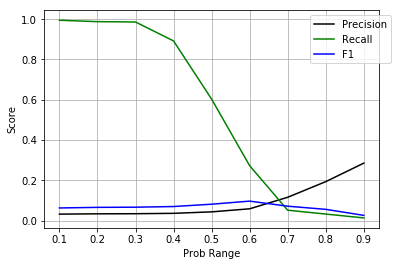

In [15]:
model_eval(X_test, y_test, logreg)
graph_eval(X_test, y_test, logreg)

Average precision-recall score: 0.06


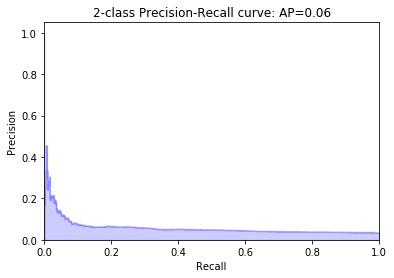

In [16]:
pr_eval(X_test, y_test, logreg)

## Oversampling using SMOTE

In [17]:
X_smote_resampled, y_smote_resampled = SMOTE().fit_sample(X_train, y_train)
print sorted(Counter(y_smote_resampled).items())

[(0.0, 70046), (1.0, 70046)]


#### Fitting, training and evaluating the model

In [18]:
logreg = LogisticRegression(C=1e90) 
logreg.fit(X_smote_resampled, y_smote_resampled)

LogisticRegression(C=1e+90, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

[[10274  7238]
 [  232   343]]
Accuracy: 58.70%
Precision: 0.045245
Recall: 0.596522
AUC: 0.623042


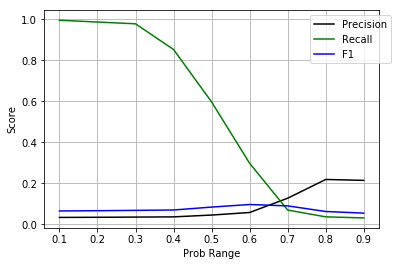

In [19]:
model_eval(X_test, y_test, logreg)
graph_eval(X_test, y_test, logreg)

Average precision-recall score: 0.06


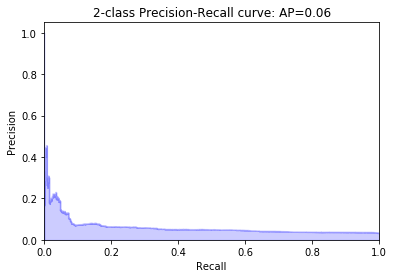

In [20]:
pr_eval(X_test, y_test, logreg)

## Oversampling using ADASYN

In [21]:
X_adasyn_resampled, y_adasyn_resampled = ADASYN().fit_sample(X_train, y_train)
print sorted(Counter(y_adasyn_resampled).items())

[(0.0, 70046), (1.0, 69586)]


#### Fitting, training and evaluating the model

In [22]:
logreg = LogisticRegression(C=1e90) 
logreg.fit(X_adasyn_resampled, y_adasyn_resampled)

LogisticRegression(C=1e+90, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

[[9503 8009]
 [ 223  352]]
Accuracy: 54.49%
Precision: 0.042100
Recall: 0.612174
AUC: 0.626547


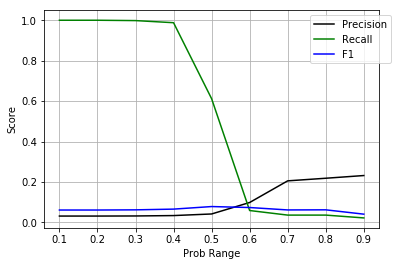

In [23]:
model_eval(X_test, y_test, logreg)
graph_eval(X_test, y_test, logreg)

Average precision-recall score: 0.06


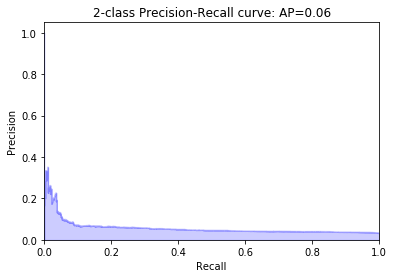

In [24]:
pr_eval(X_test, y_test, logreg)

### As you can see, the results are really bad across all 3 resampling methods. Looks like this might be a problem with the Logistic Regression model, or it might actually be the lack of clarity and telling features in the data. In the next notebook, I'll explore this same dataset using XGBoost classification model.